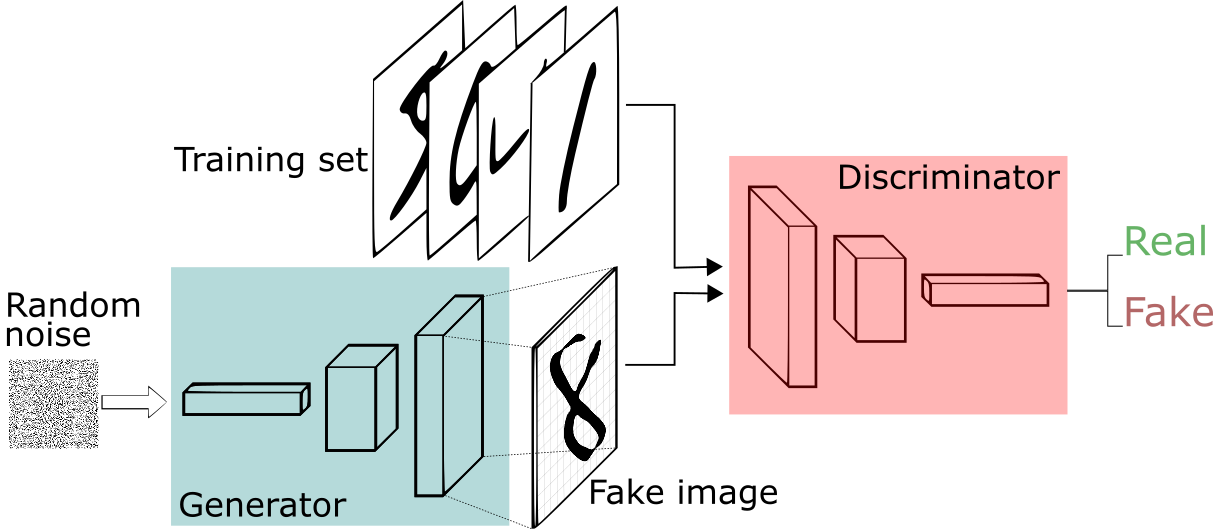

In [61]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import cv2
from sklearn.utils import shuffle


import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader


from tqdm.notebook import tqdm

# Configurations

In [252]:
device = 'cuda'
lr = 0.01

epochs = 30

BATCH_SIZE = 1024
Z_DIM = 10
LABEL_EMBED_SIZE = 10
NUM_CLASSES = 26

# Load Handwritten Alphabets Dataset

In [63]:
data = pd.read_csv('/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv')

In [64]:
my_frame = pd.DataFrame(data)

x = my_frame.drop('0', axis = 1)
y = my_frame['0']

x_train = np.reshape(x.values, (x.shape[0], 28, 28))

print('Train Data Shape:', x.shape)

Train Data Shape: (372450, 784)


In [65]:
word_dict = {
    0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X', 24:'Y',25:'Z'
}

# Load Dataset Into Batches

In [254]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = Image.fromarray(image.astype('uint8'), 'L')

        if self.transform:
            image = self.transform(image)

        # Convert image and label to torch tensors
        #image = torch.from_numpy(image)
        label = torch.tensor(label)

        return image, label

In [255]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

dataset = CustomDataset(x_train, y, transform=transform)

In [256]:
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [274]:
dataiter = iter(data_loader)
images, labels = next(dataiter)

**'display_images' : function is used to plot some of images from the batch**

In [260]:
def display_images(images, labels, word_dict, num_images=10):

    def imshow(img):
        npimg = img.detach().cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

    fig = plt.figure(figsize=(10, 10))  
    for idx in range(num_images):
        ax = fig.add_subplot(1, num_images, idx + 1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(f"{word_dict.get(labels[idx].item(), 'Unknown')}")

    plt.show()

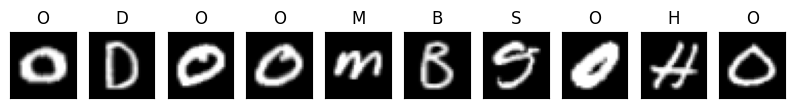

In [261]:
display_images(images, labels, word_dict, num_images=10)

# Create Discriminator Network

In [72]:
from torch.nn.modules.activation import LeakyReLU
from torch import nn

def get_disc_block(in_channels, out_channels, kernel_size, stride, padding = 0):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [73]:
class Discriminator(nn.Module):
  def __init__(self, num_classes=26):
    super(Discriminator, self).__init__()

    self.label_embedding = nn.Embedding(num_classes, 32*32)
    self.block_1 = get_disc_block(2, 32, (3,3), 2, 1)
    self.block_2 = get_disc_block(32, 64, (3,3), 2, 1)
    self.block_3 = get_disc_block(64, 128, (3,3), 2)
    self.block_4 = get_disc_block(128, 256, (3,3), 2)

    self.flatten = nn.Flatten()
    self.dropout = nn.Dropout(p=0.3)
    self.linear = nn.Linear(in_features = 256, out_features = 1)

  def forward(self, images, label):
    #print(images.shape)
    #print(label.shape)
    label_embed = self.label_embedding(label)
    #print(label_embed.shape)
    label_embed = label_embed.reshape([label_embed.shape[0], 1, 32, 32])
    #print(label_embed.shape)
    images = torch.cat((images, label_embed), dim=1)
    #print(images.shape)
    x1 = self.block_1(images)
    #print(x1.shape)
    x2 = self.block_2(x1)
    #print(x2.shape)
    x3 = self.block_3(x2)
    #print(x3.shape)
    x4 = self.block_4(x3)
    #print(x4.shape)
    x6 = self.flatten(x4)
    #print(x6.shape)
    x7 = self.dropout(x6)
    #print(x7.shape)
    x8 = self.linear(x7)
    #print(x8.shape)
    return x8

# Create Generator Network

In [74]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, padding = 0, final_block = False):
  if final_block  == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding = padding),
        nn.BatchNorm2d(out_channels),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding = padding),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [75]:
class Generator(nn.Module):
    def __init__(self, noise_dim, num_classes=26, label_embed_size=5):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim

        self.label_embedding = nn.Embedding(num_classes, label_embed_size)

        self.block_1 = get_gen_block(noise_dim + label_embed_size, 256, (4, 4), 2)

        self.block_2 = get_gen_block(256, 128, (4, 4), 2, 1)
        self.block_3 = get_gen_block(128, 64, (4, 4), 2, 1)
        self.block_4 = get_gen_block(64, 1, (4, 4), 2, 1, final_block=True)

    def forward(self, r_noise_vec, label):
        #print(r_noise_vec.shape)
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)
        #print(x.shape)
        label_embed = self.label_embedding(label)
        #print(label_embed.shape)
        label_embed = label_embed.reshape([label_embed.shape[0], -1, 1, 1])
        #print(label_embed.shape)


        x = torch.cat((x, label_embed.view(-1, label_embed.size(1), 1, 1)), dim=1)
        #print(x.shape)

        x1 = self.block_1(x)
        #print(x1.shape)
        x2 = self.block_2(x1)
        #print(x2.shape)
        x3 = self.block_3(x2)
        #print(x3.shape)
        x4 = self.block_4(x3)
        #print(x4.shape)
        #x5 = self.block_5(x4)
        #print(x5.shape)
        #x6 = self.block_6(x5)
        #print(x6.shape)

        return x4

Replace Random initialized weights to Normal weights

In [76]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

# Create Loss Function and Load Optimizer

In [77]:
def critic_loss(critic_pred, is_real):
    if is_real:
        return -torch.mean(critic_pred)
    else:
        return torch.mean(critic_pred)

def generator_loss(critic_pred):
    return -torch.mean(critic_pred)

In [262]:
D = Discriminator()
D.to(device)

G = Generator(noise_dim=10, num_classes=26, label_embed_size=5)
G.to(device)

D.apply(weights_init)
G.apply(weights_init)

Generator(
  (label_embedding): Embedding(26, 5)
  (block_1): Sequential(
    (0): ConvTranspose2d(15, 256, kernel_size=(4, 4), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block_2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block_3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (block_4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
  )
)

In [268]:
#G.load_state_dict(torch.load('/kaggle/working/G_n1.pth'))
#D.load_state_dict(torch.load('/kaggle/working/D_n1.pth'))

<All keys matched successfully>

In [91]:
#D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2), weight_decay=2e-5)
#G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2), weight_decay=2e-5)
D_opt = torch.optim.RMSprop(D.parameters(), lr=lr)
G_opt = torch.optim.RMSprop(G.parameters(), lr=lr)

In [275]:
loss_history_d = []
loss_history_g = []

In [277]:
list_size = BATCH_SIZE
number_range = 26  # Numbers from 0 to 25 inclusive
repeated_list = [i % number_range for i in range(list_size)]
all_labels = torch.tensor(repeated_list)
all_labels = all_labels.to(device)

In [331]:
def compute_gradient_penalty(D, real_samples, fake_samples, labels, device):
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    fake = torch.ones(d_interpolates.size(), device=device)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [95]:
lambda_gp = 10 
n_critic = 5

Epoch 1/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 1 | D_loss : -6.2712 | G_loss : 16.3304 | Learning Rate: 0.01


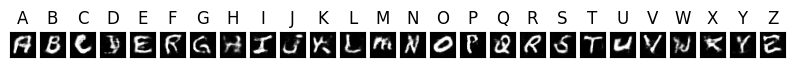

Epoch 2/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 2 | D_loss : -2.4374 | G_loss : 20.4881 | Learning Rate: 0.01


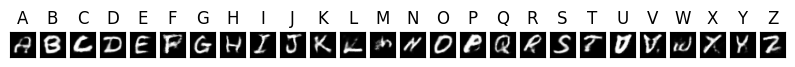

Epoch 3/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 3 | D_loss : -1.8479 | G_loss : 26.2859 | Learning Rate: 0.01


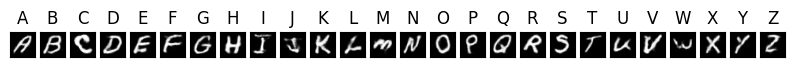

Epoch 4/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 4 | D_loss : -1.7330 | G_loss : 18.4025 | Learning Rate: 0.01


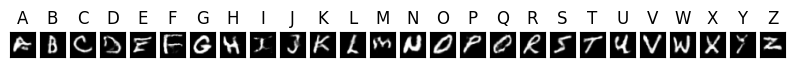

Epoch 5/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 5 | D_loss : -1.6957 | G_loss : 12.0126 | Learning Rate: 0.01


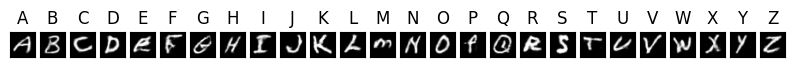

Epoch 6/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 6 | D_loss : -1.8213 | G_loss : 8.3237 | Learning Rate: 0.005


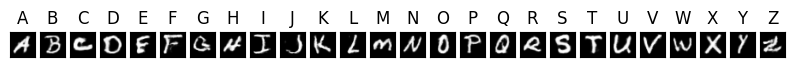

Epoch 7/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 7 | D_loss : -1.8307 | G_loss : 19.7462 | Learning Rate: 0.005


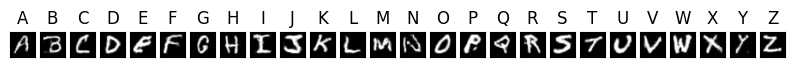

Epoch 8/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 8 | D_loss : -1.9004 | G_loss : 28.2100 | Learning Rate: 0.005


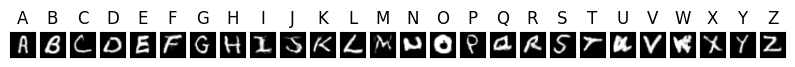

Epoch 9/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 9 | D_loss : -2.0096 | G_loss : 19.0948 | Learning Rate: 0.005


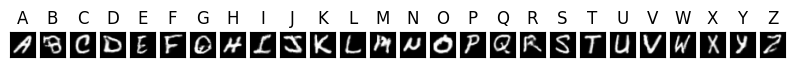

Epoch 10/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 10 | D_loss : -2.0341 | G_loss : 19.9503 | Learning Rate: 0.005


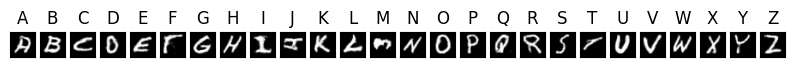

Epoch 11/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 11 | D_loss : -3.0327 | G_loss : 26.5037 | Learning Rate: 0.0025


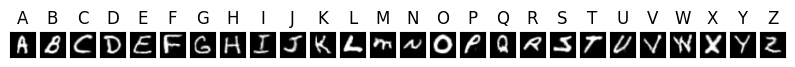

Epoch 12/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 12 | D_loss : -3.4586 | G_loss : 28.8707 | Learning Rate: 0.0025


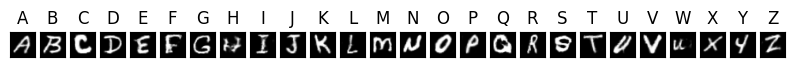

Epoch 13/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 13 | D_loss : -4.0511 | G_loss : 34.5581 | Learning Rate: 0.0025


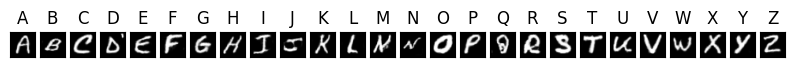

Epoch 14/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 14 | D_loss : -4.4721 | G_loss : 35.1321 | Learning Rate: 0.0025


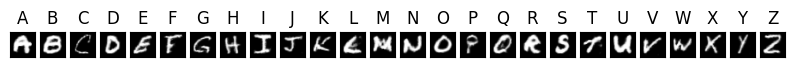

Epoch 15/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 15 | D_loss : -5.3427 | G_loss : 38.0507 | Learning Rate: 0.0025


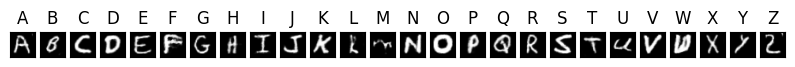

Epoch 16/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 16 | D_loss : -22.1271 | G_loss : 39.2552 | Learning Rate: 0.00125


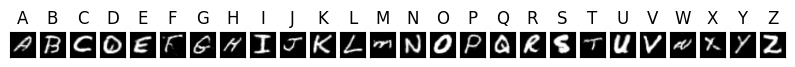

Epoch 17/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 17 | D_loss : -31.7109 | G_loss : 49.7464 | Learning Rate: 0.00125


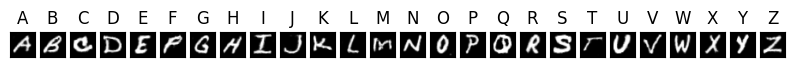

Epoch 18/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 18 | D_loss : -38.4208 | G_loss : 57.9750 | Learning Rate: 0.00125


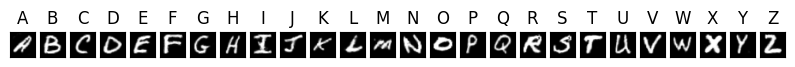

Epoch 19/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 19 | D_loss : -50.6135 | G_loss : 66.9652 | Learning Rate: 0.00125


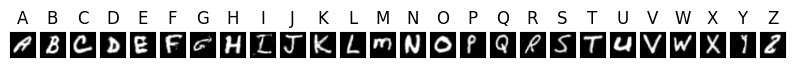

Epoch 20/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 20 | D_loss : -43.0697 | G_loss : 83.0173 | Learning Rate: 0.00125


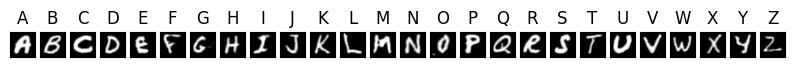

Epoch 21/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 21 | D_loss : -134.1257 | G_loss : 100.0769 | Learning Rate: 0.000625


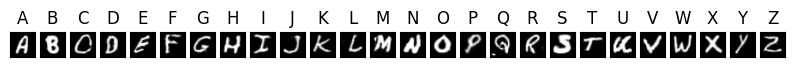

Epoch 22/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 22 | D_loss : -164.9381 | G_loss : 126.6133 | Learning Rate: 0.000625


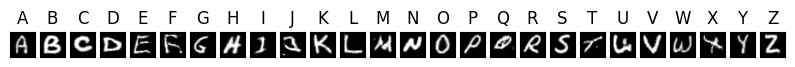

Epoch 23/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 23 | D_loss : -169.7717 | G_loss : 145.2452 | Learning Rate: 0.000625


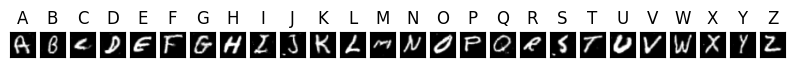

Epoch 24/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 24 | D_loss : -167.8391 | G_loss : 150.0242 | Learning Rate: 0.000625


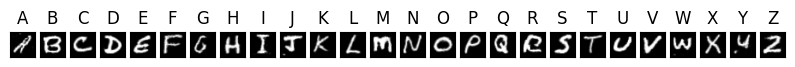

Epoch 25/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 25 | D_loss : -154.9138 | G_loss : 143.5182 | Learning Rate: 0.000625


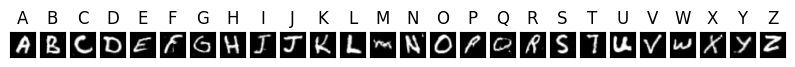

Epoch 26/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 26 | D_loss : -322.1891 | G_loss : 178.6110 | Learning Rate: 0.0003125


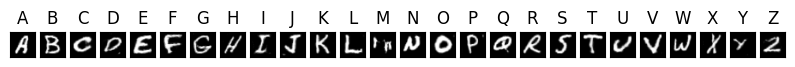

Epoch 27/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 27 | D_loss : -341.9251 | G_loss : 210.5812 | Learning Rate: 0.0003125


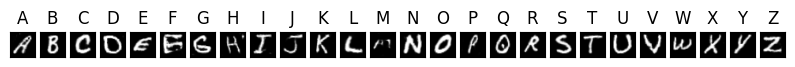

Epoch 28/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 28 | D_loss : -352.4126 | G_loss : 224.9682 | Learning Rate: 0.0003125


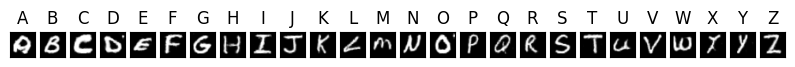

Epoch 29/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 29 | D_loss : -325.3557 | G_loss : 235.5615 | Learning Rate: 0.0003125


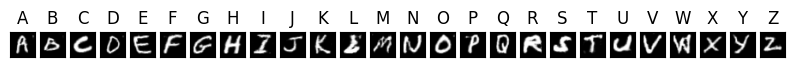

Epoch 30/30:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch : 30 | D_loss : -296.9485 | G_loss : 190.9579 | Learning Rate: 0.0003125


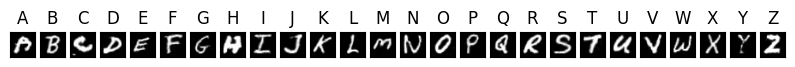

In [96]:
for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0

    data_loader_bar = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch+1}/{epochs}")

    if epoch%5 == 0 and epoch != 0:
        G_opt.param_groups[0]['lr'] /= 2
        D_opt.param_groups[0]['lr'] /= 2
        
    for i, (real_images, labels) in data_loader_bar:
        
        real_images = real_images.to(device)
        labels = labels.to(device)
        
        for _ in range(n_critic):
            D_opt.zero_grad()

            noise = torch.randn(real_images.size(0), Z_DIM, device=device)
            fake_images = G(noise, labels).detach()

            real_pred = D(real_images, labels)
            fake_pred = D(fake_images, labels)
            gradient_penalty = compute_gradient_penalty(D, real_images.data, fake_images.data, labels, device)

            D_loss = -(torch.mean(real_pred) - torch.mean(fake_pred)) + lambda_gp * gradient_penalty
            total_d_loss += D_loss.item()

            D_loss.backward()
            D_opt.step()

        G_opt.zero_grad()

        noise = torch.randn(real_images.size(0), Z_DIM, device=device)
        fake_images = G(noise, labels)

        fake_pred = D(fake_images, labels)
        G_loss = -torch.mean(fake_pred)
        total_g_loss += G_loss.item()

        G_loss.backward()
        G_opt.step()

        data_loader_bar.set_postfix(D_loss=D_loss.item(), G_loss=G_loss.item())
    
    torch.save(G.state_dict(), 'G_n1.pth')
    torch.save(D.state_dict(), 'D_n1.pth')

    avg_d_loss = total_d_loss / len(data_loader)
    avg_g_loss = total_g_loss / len(data_loader)

    print(f"Epoch : {epoch+1} | D_loss : {avg_d_loss:.4f} | G_loss : {avg_g_loss:.4f} | Learning Rate: {G_opt.param_groups[0]['lr']}")

    noise = torch.randn(BATCH_SIZE, Z_DIM, device=device)
    fake_img = G(noise, all_labels)

    display_images(fake_img, all_labels, word_dict, num_images=26)


# Generate Example Input

In [359]:
input_word = 'Generative Adversarial Network'

In [360]:
swapped_word_dic = {value: key for key, value in word_dict.items()}

In [361]:
def display_word(G, input_word, swapped_word_dic):
    num_images = len(input_word)
    def imshow(img):
        npimg = img.detach().cpu().numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    
    label_indices = [swapped_word_dic[char.upper()] if char != ' ' else ' ' for char in input_word]
    labels_filtered = [item for item in label_indices if item != ' ']
    labels = (labels_filtered * (BATCH_SIZE // len(labels_filtered) + 1))[:BATCH_SIZE]
    noise = torch.randn(BATCH_SIZE, Z_DIM, device=device)
    fake_img = G(noise, all_labels)

    fig = plt.figure(figsize=(10, 10))  
    for i, idx in enumerate(label_indices):
        ax = fig.add_subplot(1, num_images, i + 1, xticks=[], yticks=[])
        if idx != ' ':
            imshow(fake_img[idx])
            ax.set_title(f"{word_dict[idx]}")
        else:
            ax.axis('off')
        

    plt.show()

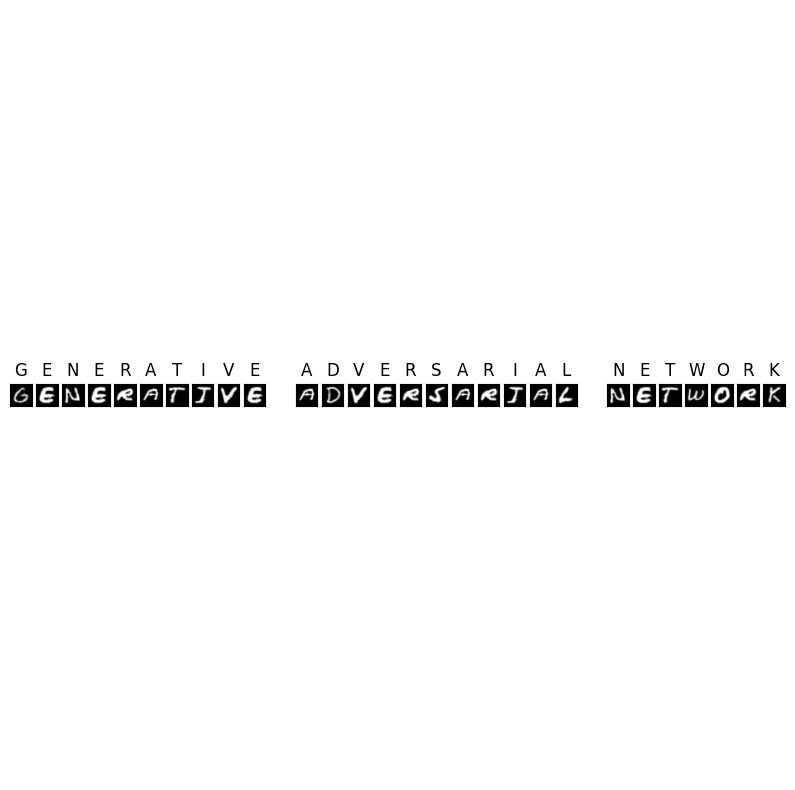

In [362]:
display_word(G, input_word, swapped_word_dic)

# Save the model

In [ ]:
torch.save(G.state_dict(), 'G.pth')
torch.save(D.state_dict(), 'D.pth')